In [1]:
import json
import os
import re
import glob
from pathlib import Path
from tqdm.notebook import tqdm
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import scipy

from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Geometry.rdGeometry import Point2D
from PIL import Image as PILImage
import IPython.display
import io
import rdkit
from matplotlib.pyplot import figure
from tqdm.notebook import trange
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

## Load data

In [2]:
base_path = Path(os.getcwd()).parent
data_dir = base_path / 'data/protobind_diff' / 'attention'

In [3]:
seq_pdb = "ASMEDYVNFNFEDFYCEKNNVRQFASHFLPPLYWLVFIVGALGNSLVILVYWYCARAKTATDMFLLNLAIADLLFLVTLPFWAIAAADQWKFQTFMCKVVNSMYKMNFYSCVLLIMCICVDRYIAIAQAMRAHTWREKRLLYSKMVCFTIWVLAAALCIPEILYSQIKEESGIAICTMVYPSDESTKLKSAVLALKVILGFFLPFVVMACCYTIIIHTLIQAKKSSKHKALKATITVLTVFVLSQFPYNCILLVQTIDAYAMFISNCAVSTAIDICFQVTQAIAFFHSCLNPVLYVFVGERFRRDLVKTLKNLGAISQAAAHHHHHHHHHH"
seq_canonical = 'MTPTDFTSPIPNMADDYGSESTSSMEDYVNFNFTDFYCEKNNVRQFASHFLPPLYWLVFIVGALGNSLVILVYWYCTRVKTMTDMFLLNLAIADLLFLVTLPFWAIAAADQWKFQTFMCKVVNSMYKMNFYSCVLLIMCISVDRYIAIAQAMRAHTWREKRLLYSKMVCFTIWVLAAALCIPEILYSQIKEESGIAICTMVYPSDESTKLKSAVLTLKVILGFFLPFVVMACCYTIIIHTLIQAKKSSKHKALKVTITVLTVFVLSQFPYNCILLVQTIDAYAMFISNCAVSTNIDICFQVTQTIAFFHSCLNPVLYVFVGERFRRDLVKTLKNLGCISQAQWVSFTRREGSLKLSSMLLETTSGALSL'

In [4]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

alignments = pairwise2.align.globalms(seq_pdb, seq_canonical, 5, -4, -3, -.1)
aln_seq1, aln_seq2, score, start, end = alignments[0]

match_line = ''
nums = ''
for a, b in zip(aln_seq1, aln_seq2):
    if a == b:
        match_line += '|'
    elif a == '-' or b == '-':
        match_line += ' '
    else:
        match_line += '*'

chunk_size = 90
i1, i2 = 0, 0

for i in range(0, len(aln_seq1), chunk_size):
    s1_chunk = aln_seq1[i:i+chunk_size]
    s2_chunk = aln_seq2[i:i+chunk_size]
    match_chunk = match_line[i:i+chunk_size]

    s1_start = i1 + 1
    s2_start = i2 + 1
    i1 += s1_chunk.count('-') ^ 1 and len(s1_chunk.replace('-', ''))
    i2 += s2_chunk.count('-') ^ 1 and len(s2_chunk.replace('-', ''))
    s1_end = i1
    s2_end = i2

    print(f"Pdb {s1_start:>5}-{s1_end:<5}  {s1_chunk}")
    print(f"                 {match_chunk}")
    print(f"Can {s2_start-1:>5}-{s2_end-1:<5}  {s2_chunk}")
    print()
    print()

Pdb     1-68     -------------A---------SMEDYVNFNFEDFYCEKNNVRQFASHFLPPLYWLVFIVGALGNSLVILVYWYCARAKTATDMFLLNL
                              |         ||||||||||*||||||||||||||||||||||||||||||||||||||||||*|*||*||||||||
Can     0-89     MTPTDFTSPIPNMADDYGSESTSSMEDYVNFNFTDFYCEKNNVRQFASHFLPPLYWLVFIVGALGNSLVILVYWYCTRVKTMTDMFLLNL


Pdb    69-158    AIADLLFLVTLPFWAIAAADQWKFQTFMCKVVNSMYKMNFYSCVLLIMCICVDRYIAIAQAMRAHTWREKRLLYSKMVCFTIWVLAAALC
                 ||||||||||||||||||||||||||||||||||||||||||||||||||*|||||||||||||||||||||||||||||||||||||||
Can    90-179    AIADLLFLVTLPFWAIAAADQWKFQTFMCKVVNSMYKMNFYSCVLLIMCISVDRYIAIAQAMRAHTWREKRLLYSKMVCFTIWVLAAALC


Pdb   159-248    IPEILYSQIKEESGIAICTMVYPSDESTKLKSAVLALKVILGFFLPFVVMACCYTIIIHTLIQAKKSSKHKALKATITVLTVFVLSQFPY
                 |||||||||||||||||||||||||||||||||||*||||||||||||||||||||||||||||||||||||||*|||||||||||||||
Can   180-269    IPEILYSQIKEESGIAICTMVYPSDESTKLKSAVLTLKVILGFFLPFVVMACCYTIIIHTLIQAKKSSKHKALKVTITVLTVFVLSQFPY


Pdb   249-319    NCILL

/data/venv/cmap_py/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [5]:
def tokenize_smiles(smiles):
    pattern = r'\[[^\[\]]+\]|[^ \[\]]'
    return re.findall(pattern, smiles)


def get_mol_indexes(idx, head, plot_threshold=0.75, imp=1):

    def extract_number(elem):
        if '[' in elem and ']' in elem:
            match = re.search(r':(\d+)', elem)
            return int(match.group(1)) if match else 0
        else:
            return 0

    seq_len = len(idx_to_seq[sequence_ids[idx]])
    molecule = gen_mols[idx]
    BOS = np.where(tokens[idx] == 2)[0][0]
    EOS = np.where(tokens[idx] == 3)[0][0]
    
    attention_map = att_maps[idx][head][BOS+1:EOS, :seq_len]
    seq_sum = attention_map.sum(axis=0)
    seq_sum_sorted = np.sort(seq_sum)
    
    max_v = seq_sum_sorted[-imp]
    idx_att = np.where(seq_sum == max_v)[0][0]
    token_importance = attention_map[:, idx_att]
    
    indexes = np.where(token_importance > plot_threshold)
    indexes_importance = token_importance[token_importance > plot_threshold]

    # add atom indexes to SMILES
    molecule = Chem.MolFromSmiles(molecule)
    for atom in molecule.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    
    # Chem.MolToSmiles save_canonical=True
    separate_blocks = np.array(tokenize_smiles(Chem.MolToSmiles(molecule)))[indexes]
    
    mask = np.array([bool(re.search(r'[a-zA-Z]', elem)) for elem in separate_blocks])
    separate_blocks = separate_blocks[mask]
    numbers = np.array([extract_number(elem) for elem in separate_blocks])
    important_idxs = [int(idx) for idx in numbers]
    importance = [float(value) for value in indexes_importance[mask]]
    
    return important_idxs, importance, idx_att

## Load attention weights

In [6]:
gen_mols = np.load(data_dir / f'generated_CCR9_gen_mols.npy')
att_maps = np.load(data_dir / f'generated_CCR9_attention.npy')
tokens = np.load(data_dir / f'generated_CCR9_tokens.npy')
sequence_ids = np.load(data_dir / f'generated_CCR9_sequence_ids.npy')

## Draw molecule and sequence

In [7]:
idx_to_seq = {4006: seq_canonical}
int2genes = {4006: 'CCR9'}

In [8]:
tokens

array([[ 2,  8, 10,  9,  8,  8, 10, 11, 13, 14, 13, 13, 13, 11, 24, 17,
        13, 11, 10, 23, 11,  7,  6, 17, 11,  7,  6, 17, 13, 20, 13, 13,
        13, 11,  8, 11,  8, 17, 11,  8, 17,  8, 17, 13, 13, 20, 17, 13,
        14, 17,  8,  8,  9,  3,  0],
       [ 2,  8,  8,  9, 11,  8, 17,  8, 11,  7,  6, 17, 13, 14, 13, 13,
        11, 10,  8, 11,  7,  6, 17, 10, 13, 20, 15, 15, 13, 11, 31, 13,
        29, 13, 13, 13, 11, 24, 17, 13, 13, 29, 17, 32, 20, 17, 13, 13,
        13, 14,  9,  3,  0,  0,  0],
       [ 2,  6,  7,  8,  9, 10,  8,  8, 11, 13, 14, 13, 13, 11, 21, 17,
        13, 13, 13, 14, 24, 17,  8,  9, 10, 23, 11,  7,  6, 17, 11,  7,
         6, 17, 13,  9, 13, 13, 13, 11, 24, 17, 13, 13,  9,  3,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [ 2,  6,  7, 23, 11,  7,  6, 17, 11, 10, 13,  9, 15, 13, 11,  8,
         6, 17, 13, 30,  9, 17, 13,  9, 13, 13, 14, 13, 13, 13, 13, 13,
        14, 30,  9,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(12, 20), dpi=500, gridspec_kw={'wspace': 0.0, 'hspace': 0.7})
axes = axes.flatten()
n_heads = 8
idx = 1
for i in range(n_heads):
    seq_len = len(idx_to_seq[sequence_ids[idx]])
    BOS = np.where(tokens[idx] == 2)[0][0]
    EOS = np.where(tokens[idx] == 3)[0][0]
    ligand_len = EOS
    attention_map = att_maps[idx][i][1:ligand_len, :seq_len]
    # attention maps often have a long tail distribution: a few high values and many low values close to zero
    threshold = np.percentile(attention_map, 90)
    mask = attention_map < threshold
    attention_map[mask] = 0
    
    img = sns.heatmap(attention_map, cmap='Blues', ax=axes[i]) 
    if i < n_heads-1:
        img.set_xlabel('')
    else:
        img.set_xlabel('Sequence')
    img.set_title(f'Molecule {idx}, head {i+1}')
plt.show();

In [23]:
int2letter

{0: 'M',
 1: 'T',
 2: 'P',
 3: 'T',
 4: 'D',
 5: 'F',
 6: 'T',
 7: 'S',
 8: 'P',
 9: 'I',
 10: 'P',
 11: 'N',
 12: 'M',
 13: 'A',
 14: 'D',
 15: 'D',
 16: 'Y',
 17: 'G',
 18: 'S',
 19: 'E',
 20: 'S',
 21: 'T',
 22: 'S',
 23: 'S',
 24: 'M',
 25: 'E',
 26: 'D',
 27: 'Y',
 28: 'V',
 29: 'N',
 30: 'F',
 31: 'N',
 32: 'F',
 33: 'T',
 34: 'D',
 35: 'F',
 36: 'Y',
 37: 'C',
 38: 'E',
 39: 'K',
 40: 'N',
 41: 'N',
 42: 'V',
 43: 'R',
 44: 'Q',
 45: 'F',
 46: 'A',
 47: 'S',
 48: 'H',
 49: 'F',
 50: 'L',
 51: 'P',
 52: 'P',
 53: 'L',
 54: 'Y',
 55: 'W',
 56: 'L',
 57: 'V',
 58: 'F',
 59: 'I',
 60: 'V',
 61: 'G',
 62: 'A',
 63: 'L',
 64: 'G',
 65: 'N',
 66: 'S',
 67: 'L',
 68: 'V',
 69: 'I',
 70: 'L',
 71: 'V',
 72: 'Y',
 73: 'W',
 74: 'Y',
 75: 'C',
 76: 'T',
 77: 'R',
 78: 'V',
 79: 'K',
 80: 'T',
 81: 'M',
 82: 'T',
 83: 'D',
 84: 'M',
 85: 'F',
 86: 'L',
 87: 'L',
 88: 'N',
 89: 'L',
 90: 'A',
 91: 'I',
 92: 'A',
 93: 'D',
 94: 'L',
 95: 'L',
 96: 'F',
 97: 'L',
 98: 'V',
 99: 'T',
 100: 'L',

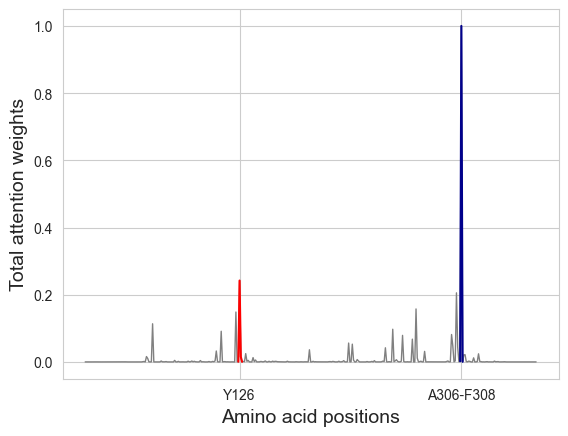

In [26]:
head = 7

fig = plt.figure(dpi=100)

seq_len = len(idx_to_seq[sequence_ids[idx]]) # get target id and convert to fasta
BOS = np.where(tokens[idx] == 2)[0][0]
EOS = np.where(tokens[idx] == 3)[0][0]
attention_map = att_maps[idx][head][BOS+1:EOS, :seq_len]
seq_sum = attention_map.sum(axis=0)

seq = idx_to_seq[sequence_ids[idx]]
int2letter = dict(zip(np.arange(1, len(seq)), list(seq)))

site2letter = [126, 307]
site2letter = dict(zip(site2letter, [int2letter[pos]+str(pos) for pos in site2letter]))
site2letter[307] = 'A306-F308' # the 1st peak is wider
site2letter

x, y = np.arange(len(seq_sum)), seq_sum
y /= np.max(y)
plt.plot(x, y, color='gray', linewidth=1)

mask = (x >= 125) & (x <= 128)
plt.plot(x[mask], y[mask], color='red')
         
mask = (x >= 306) & (x <= 308)
plt.plot(x[mask], y[mask], color='darkblue')

plt.xticks(ticks=list(site2letter.keys()), labels=list(site2letter.values()))
plt.xlabel('Amino acid positions', size=14)
plt.ylabel('Total attention weights', size=14);

/tmp/ipykernel_539145/514057543.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


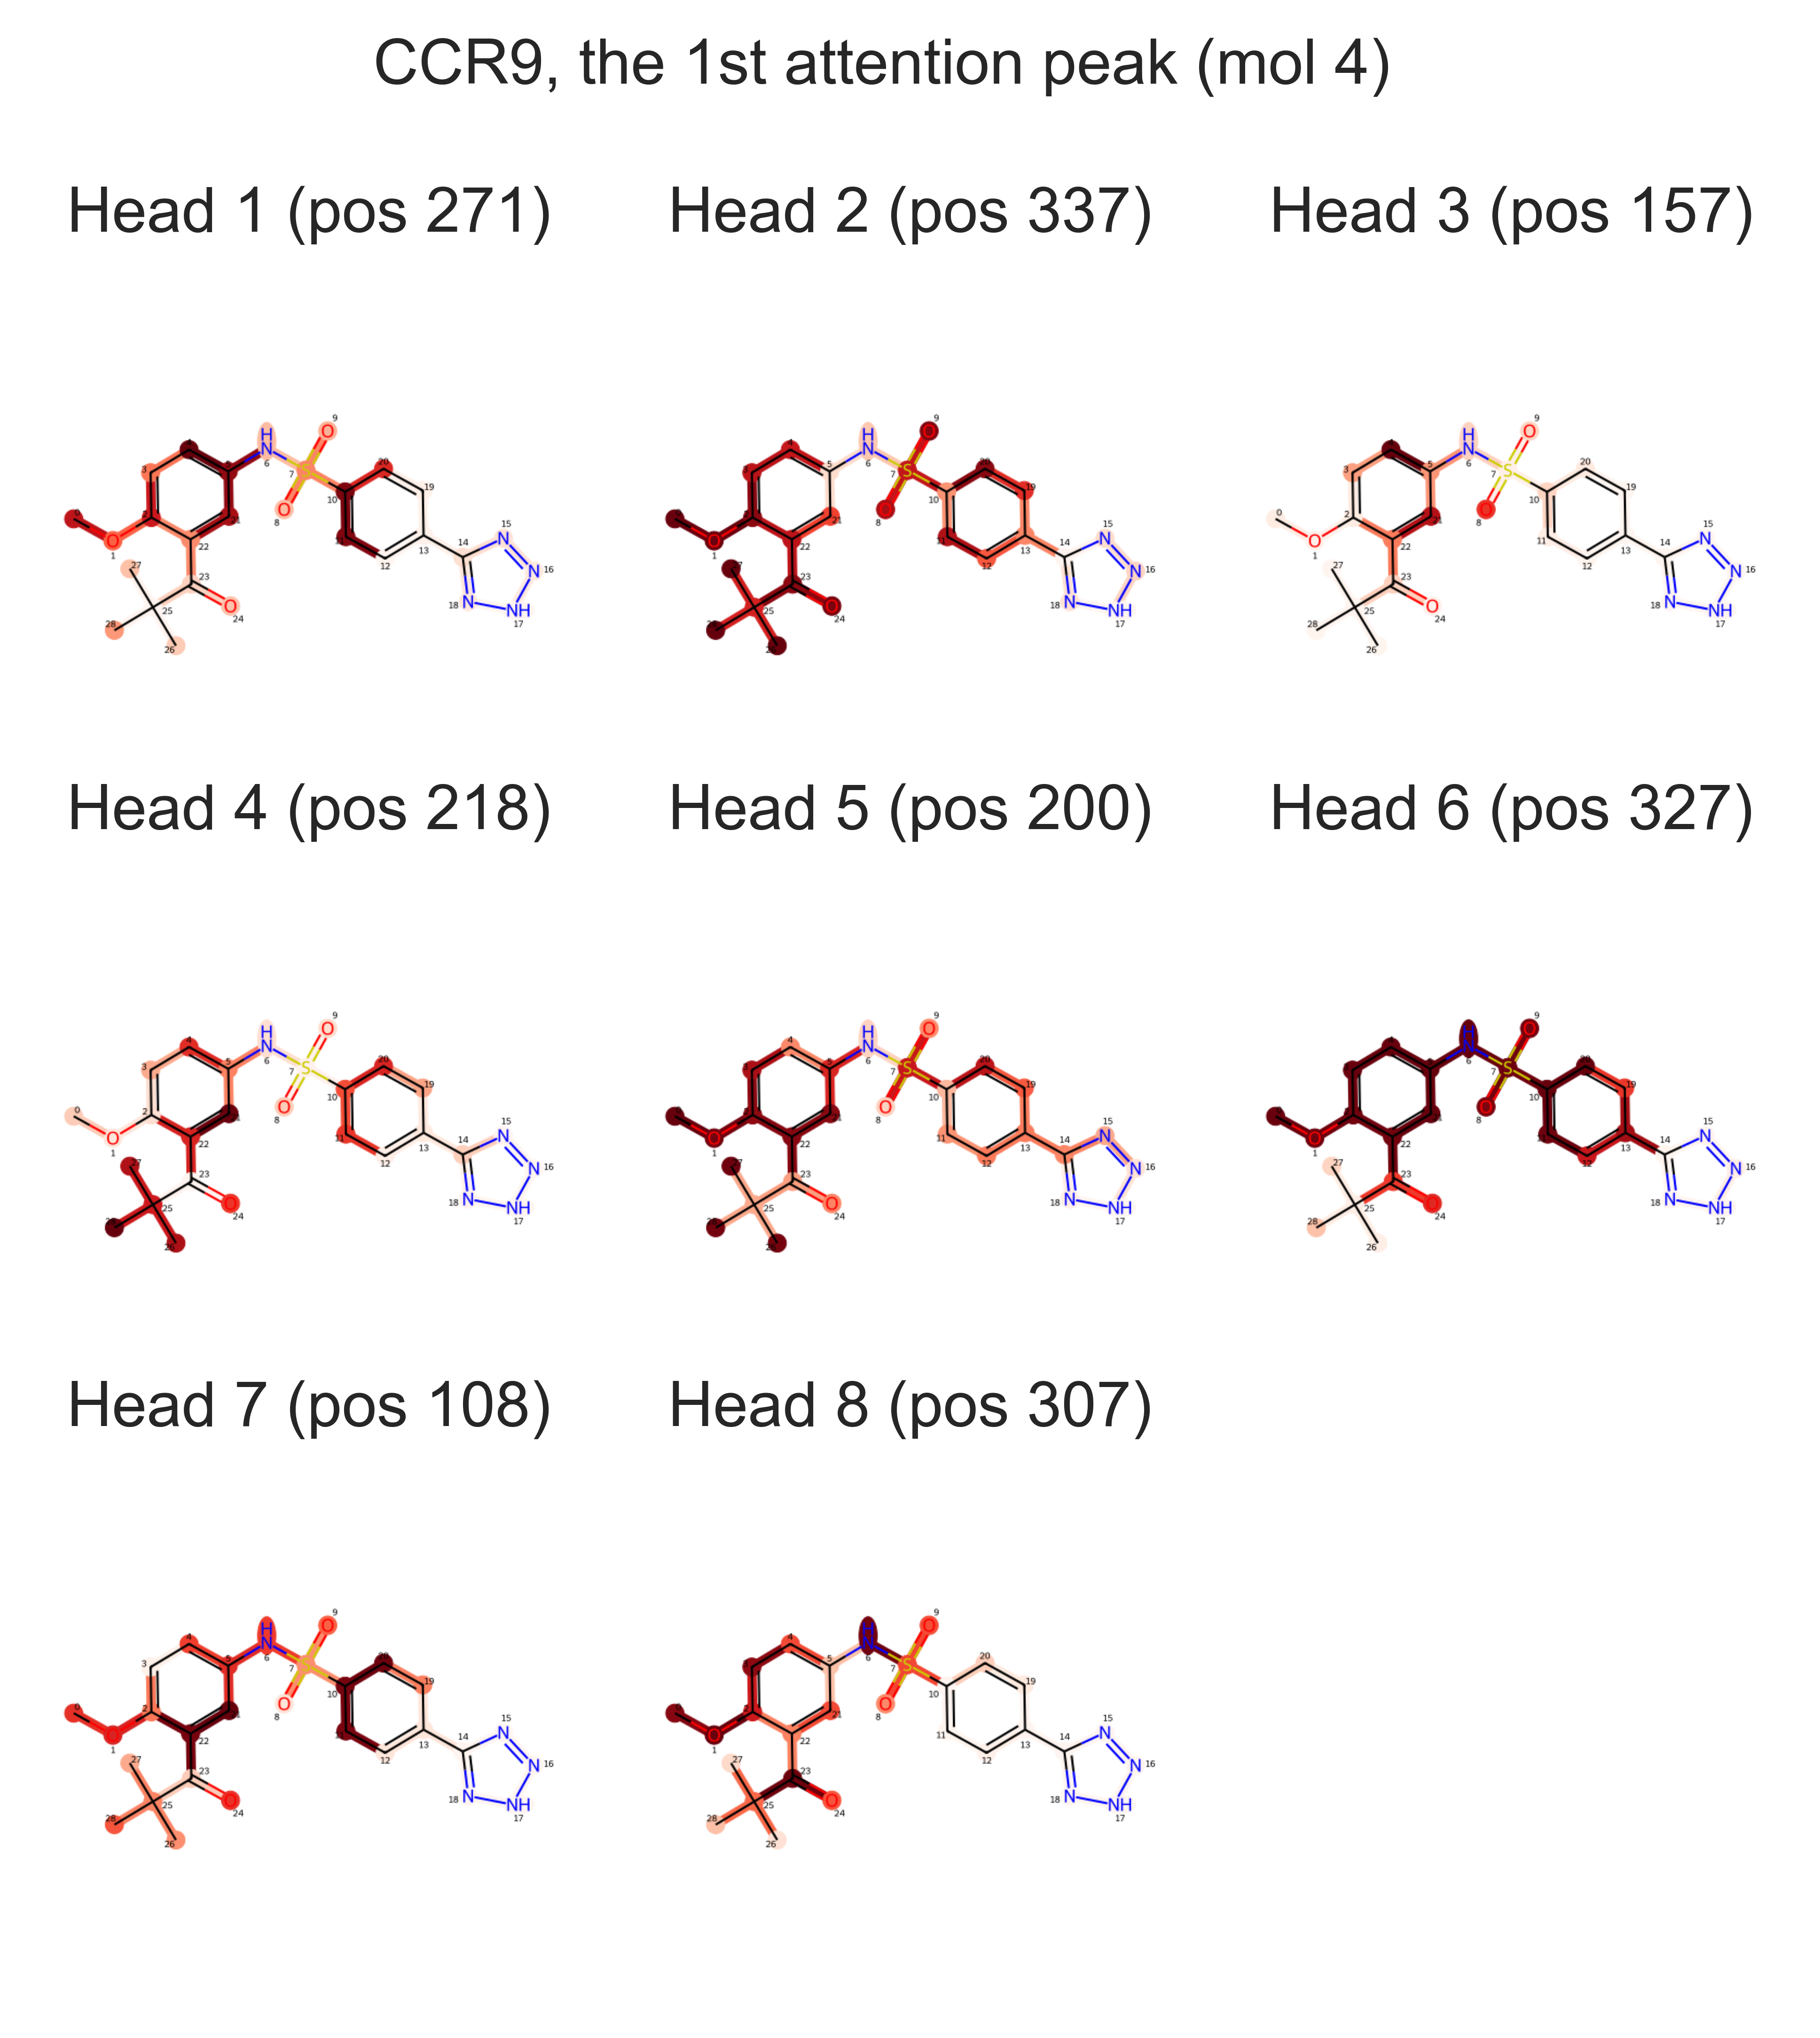

In [27]:
# molecule idx
idx = 4

# draw attention at the biggest attention peak
imp_rank = 1

######## plot molecule ########
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6), dpi=800, gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
axes = axes.flatten()
n_heads = att_maps.shape[1]

for i in range(n_heads):
    important_idxs, importance, idx_att = get_mol_indexes(idx, i, plot_threshold=0.0, imp=imp_rank)
    if imp_rank == 1:
        cmap = plt.cm.Reds
    elif imp_rank == 2:
        cmap = plt.cm.Greens
    else:
        raise 
    molecule = Chem.MolFromSmiles(gen_mols[idx])
    
    norm = plt.Normalize(vmin=min(importance), vmax=max(importance))
    colors = cmap(norm(importance))
    colors = [(float(v1), float(v2), float(v3), float(v4)) for (v1, v2, v3, v4) in colors]
    index_to_color = dict(zip(important_idxs, colors))
    
    d = rdMolDraw2D.MolDraw2DCairo(500, 500)
    d.drawOptions().addStereoAnnotation = False
    d.drawOptions().addAtomIndices = True
    d.DrawMolecule(molecule, highlightAtoms=important_idxs, highlightAtomColors=index_to_color)
    d.FinishDrawing()
    png_data = d.GetDrawingText()

    image = PILImage.open(io.BytesIO(png_data))
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Head {i+1} (pos {idx_att})")

axes[-1].set_visible(False)
plt.suptitle(f'{int2genes[sequence_ids[idx]].upper()}, the 1st attention peak (mol {idx})')
plt.tight_layout()
plt.show()

/tmp/ipykernel_539145/784067363.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


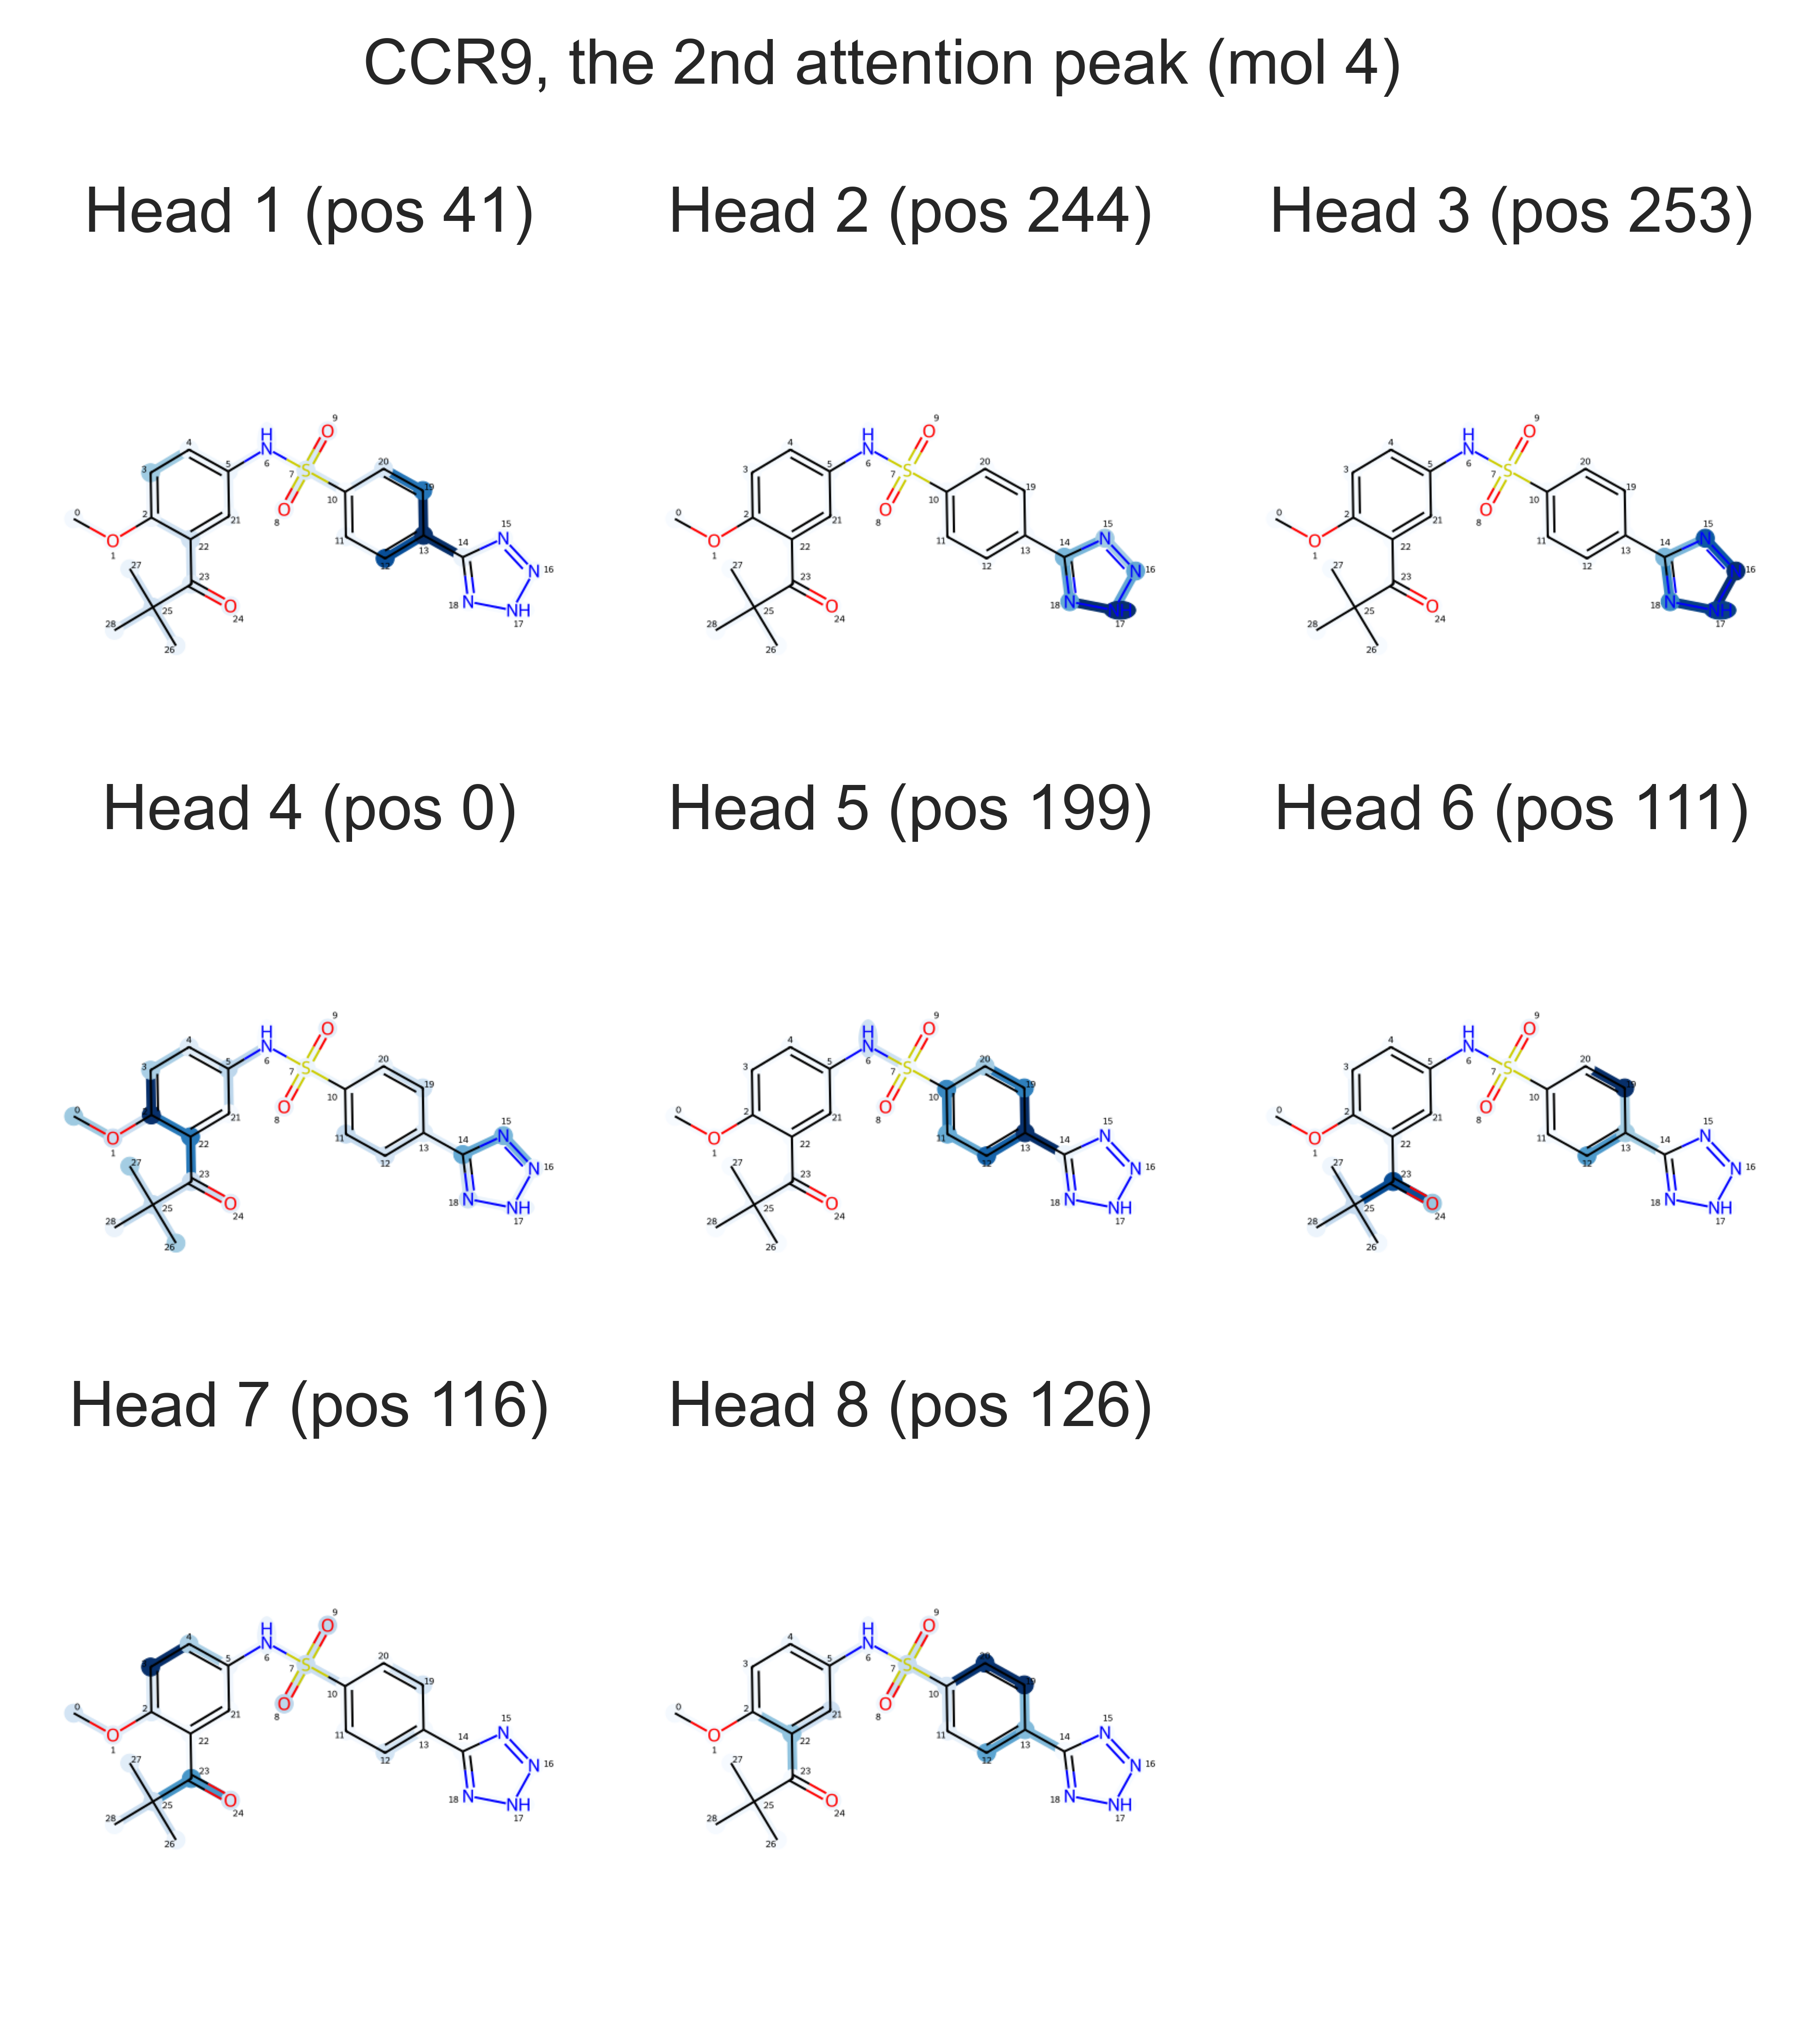

In [28]:
# draw attention at the second attention peak
imp_rank = 2


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6), dpi=800, gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
axes = axes.flatten()
n_heads = att_maps.shape[1]

for i in range(n_heads):
    important_idxs, importance, idx_att = get_mol_indexes(idx, i, plot_threshold=0.0, imp=imp_rank)
    if imp_rank == 1:
        cmap = plt.cm.Greens
    elif imp_rank == 2:
        cmap = plt.cm.Blues
    else:
        raise 
    molecule = Chem.MolFromSmiles(gen_mols[idx])
    
    norm = plt.Normalize(vmin=min(importance), vmax=max(importance))
    colors = cmap(norm(importance))
    colors = [(float(v1), float(v2), float(v3), float(v4)) for (v1, v2, v3, v4) in colors]
    index_to_color = dict(zip(important_idxs, colors))
    
    d = rdMolDraw2D.MolDraw2DCairo(500, 500)
    d.drawOptions().addStereoAnnotation = False
    d.drawOptions().addAtomIndices = True
    d.DrawMolecule(molecule, highlightAtoms=important_idxs, highlightAtomColors=index_to_color)
    d.FinishDrawing()
    png_data = d.GetDrawingText()

    image = PILImage.open(io.BytesIO(png_data))
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Head {i+1} (pos {idx_att})")

axes[-1].set_visible(False)
plt.suptitle(f'{int2genes[sequence_ids[idx]].upper()}, the 2nd attention peak (mol {idx})')
plt.tight_layout()
plt.show()